In [ ]:
#this is a roadmap from beginning truth to the final iteration of iPto19

In [8]:
import cobra
from cobra import Model, Gene, Reaction, Metabolite
import pandas as pd
import medusa
from medusa.test import load_universal_modelseed
import csv
import matplotlib.pylab as plt
from pickle import load

V1 was originally created from the feeder document, which was derived from looking at reactions present in the draft reconstruction and confirming the activity and presence of an enzyme. This is the document that starts the whole process. It was converted first into an sbml file format to be later read as a cobra model object. 

In [2]:
#these are the universal variables 
seed_draft = cobra.io.load_json_model('../data/modelseed_data/modelseed_draft_psy_DC3000.json')
universal = load_universal_modelseed()
filepath_model = "../results/reconstructions/"
filesuff_xml = ".xml"
filesuff_csv = ".csv"
pa = cobra.io.read_sbml_model('../data/previous_reconstructions/iPAE1146.xml')

Model does not contain SBML fbc package information.
SBML package 'layout' not supported by cobrapy,information is not parsed
SBML package 'render' not supported by cobrapy,information is not parsed
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_cpd00015_c "FAD">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_cpd03128_c "Decanoyl-CoA">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_cpd00982_c "FADH2">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_cpd03129_c "(2E)-Decenoyl-CoA">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_cpd01260_c "Lauroyl-CoA">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_cpd02060_c "(2E)-Dodecenoyl-CoA">
Use of FORMULA in the notes element is discouraged, use fbc:chemical

In [3]:
#this is a general excel script that is used to convert each of the excel files into a json model, which is then converted into an sbml model for ease of access
#generate the list of reactions to be used for generating the model, from the curation file
pst_feeder_xl_file = pd.read_excel('../data/PST_feeder.xlsx')

filevar = "pst_feeder"

#at this point we have a grab bag of reactions ready to be inserted into the model, which we have yet to create

model = Model('PST') #empty model

#add reactions from the grab bag
for i in range(0,len(pst_feeder_xl_file)):
    reaction_row = pst_feeder_xl_file.iloc[i,]
    reaction_id = str(reaction_row['Reaction ID'])[:-1]
    reaction_to_add = universal.reactions.get_by_id(reaction_id).copy()
    reaction_to_add.subsystem = reaction_row ['Subsystems'] #add subsystem for the reaction 
    reaction_to_add.gene_reaction_rule = reaction_row['GPR'] #add gpr for the reaction
    model.add_reaction(reaction_to_add)

save_dir_model = filepath_model+filevar+filesuff_xml
write_dir = filepath_model + filevar + filesuff_csv

with open(write_dir, 'w', newline='') as csvfile:
    csvfile = csv.writer(csvfile, delimiter=',')
    for rxn in model.reactions:
        csvfile.writerow([rxn.id, rxn.name, rxn.reaction, rxn.gene_reaction_rule,rxn.lower_bound, rxn.upper_bound])

cobra.io.write_sbml_model(model, save_dir_model)

Ignoring reaction 'rxn00182_c' since it already exists.
Ignoring reaction 'rxn00260_c' since it already exists.
Ignoring reaction 'rxn00493_c' since it already exists.
Ignoring reaction 'rxn00527_c' since it already exists.
Ignoring reaction 'rxn01640_c' since it already exists.


V1 was not integrated with the orthologs between PAO1 and Pst yet. So, there are a few scripts and outputs that achive this. Originally, this was done through the scripts "ortholog_compiler", "comp_list", "rxns_left", "rxn_list_comp" all feeding into the newly updated PST_curation.xlsx. I will combine all the scripts here in the next cells.

In [4]:
#generate the list of reactions to be used for generating the pseudomonas aerugniosa model, from the curation file
pa_xl_file = pd.read_excel('../data/SupplementaryData4_mPAO1.xlsx')

PA = Model('PA') #empty model

#add reactions from the grab bag
for i in range(0,len(pa_xl_file)):
    reaction_row = pa_xl_file.iloc[i,]
    reaction_id = reaction_row['Abbreviation'] + '_c'
    try:
        reaction_to_add = universal.reactions.get_by_id(reaction_id).copy()
        reaction_to_add.subsystem = reaction_row ['Subsystems'] #add subsystem for the reaction 
        reaction_to_add.gene_reaction_rule = reaction_row['GPR'] #add gpr for the reaction
        PA.add_reaction(reaction_to_add)
    except:
        pass

In [5]:
filevar = "PSTv1"

#this is the script originally called "ortholog_to_list.py" which was used to compare the PAO1 and PST orthologs to the list of PAO1 gprs in PAO1 reactions
#followed by comparing the list of PAO1 reactions to the list of reactions left to be curated in PST draft. If there is an ortholog between PAO1 and PSt, and it has a
#matching reaction that is defined in PAO1, the reaction will be added to a list with updated orthologous genes in PST.
#read the two library files for the lists, as well as the reaction list to call reactions
orthologs = pd.read_csv('../data/previous_data_from_curation/PA01_PSY_orthologs.csv')

#now we have the reactions extracted into a list to compare with the pa01 library, which must be similarly compared
#when comparing the reaction, create a dictionary with the reaction id as the key and the genes as the value
pao1_reactions_to_genes = {}
#extract the reactions from pao1 and the corresponding genes to create a dictionary
for rxn in PA.reactions:
    #populate the dictionary with the keys (rxn abbreviations) and values (gene ids)
    pao1_reactions_to_genes[rxn.id] = rxn.gene_reaction_rule  

#now compare the dictionary keys (rxns) to the list of rxns in the PST update list of rxns, rxn_list

matching_rxns = {}
for k in seed_draft.reactions:
    if k.id in pao1_reactions_to_genes:
        str_pao1_genes = str(pao1_reactions_to_genes[k.id])
        split_genes = str.split(str_pao1_genes, ' ')
        matching_rxns[k] = split_genes        

#this has the format that I want, but now add to a pandas dataframe
df_matching_rxns = pd.DataFrame.from_dict(matching_rxns, orient='index')

#dataframe is now in the format to be used. it includes the reaction ids and the associated genes
#now I must match the asociated genes with the orthologous pairs
#first create dictionary with the orthologous pairs
ortholog_dict = {}

for x in range(0, len(orthologs)):
    pair_row = orthologs.iloc[x,]
    query = pair_row['Locus Tag (Query)']
    result = pair_row['Locus Tag (Hit)']
    ortholog_dict[query]=result

#the ortholog dict is assembled, with each query value (all Pao1 genes and PSPTO genes were surveyed)
#this dict will now be iterated over to match with the missing reactions PAo1 genes
rxn_PST = {}
for k,v in matching_rxns.items():
    for x in v:
        if x in ortholog_dict:
            rxn_PST[k.id] = ortholog_dict[x]
        else:
            pass

        
for key,value in rxn_PST.items():
    try:
        rxn_to_add = universal.reactions.get_by_id(key).copy()
        rxn_to_add.gene_reaction_rule = value
        model.add_reactions([rxn_to_add])
    except:
        pass


save_dir_model = filepath_model+filevar+filesuff_xml
write_dir = filepath_model + filevar + filesuff_csv

with open(write_dir, 'w', newline='') as csvfile:
    csvfile = csv.writer(csvfile, delimiter=',')
    for rxn in model.reactions:
        csvfile.writerow([rxn.id, rxn.name, rxn.reaction, rxn.gene_reaction_rule,rxn.lower_bound, rxn.upper_bound])

cobra.io.write_sbml_model(model, save_dir_model)



Ignoring reaction 'rxn00646_c' since it already exists.
Ignoring reaction 'rxn02944_c' since it already exists.
Ignoring reaction 'rxn01636_c' since it already exists.
Ignoring reaction 'rxn05221_c' since it already exists.
Ignoring reaction 'rxn01640_c' since it already exists.
Ignoring reaction 'rxn00060_c' since it already exists.
Ignoring reaction 'rxn02264_c' since it already exists.
Ignoring reaction 'rxn00433_c' since it already exists.
Ignoring reaction 'rxn05581_c' since it already exists.
Ignoring reaction 'rxn00708_c' since it already exists.
Ignoring reaction 'rxn00029_c' since it already exists.
Ignoring reaction 'rxn00555_c' since it already exists.
Ignoring reaction 'rxn05164_c' since it already exists.
Ignoring reaction 'rxn03540_c' since it already exists.
Ignoring reaction 'rxn00838_c' since it already exists.
Ignoring reaction 'rxn00527_c' since it already exists.
Ignoring reaction 'rxn00966_c' since it already exists.
Ignoring reaction 'rxn05574_c' since it already 

In [6]:
filevar = "PSTv2"
#biomass reactions are temporarily added for gapfilling purposes
bio1 = pa.reactions.PAO1_Biomass.copy()
bio2 = pa.reactions.PA_Biomass_v13ub.copy()
bio3 = pa.reactions.PA_Biomass_v13.copy()
bio4 = pa.reactions.PA_Biomass_v4.copy()
model.add_reactions([bio1, bio2, bio3, bio4])


save_dir_model = filepath_model+filevar+filesuff_xml
write_dir = filepath_model + filevar + filesuff_csv

with open(write_dir, 'w', newline='') as csvfile:
    csvfile = csv.writer(csvfile, delimiter=',')
    for rxn in model.reactions:
        csvfile.writerow([rxn.id, rxn.name, rxn.reaction, rxn.gene_reaction_rule,rxn.lower_bound, rxn.upper_bound])

cobra.io.write_sbml_model(model, save_dir_model)

To get from v2 to v3 is the next step. This is the point where we added a lot of nomenclature for satisfying MEMOTE, including the inchie strings and other database knowledge.

/Users/phil/cobrapython/lib/python3.7/site-packages/ipykernel_launcher.py:25 FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



KeyError: 'Inulin'

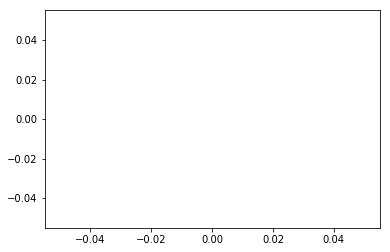

In [9]:
#gapfill number one, this will add in all exchange reactions and never have to be initiated again
# loop through the sheets of the spreadsheet; each sheet is a biological replicate
# of all 3 of the biolog plates. Columns are time in hours.
reps = {}
for i in range(0,4):
    biolog_raw = pd.read_excel('../data/experiments/biolog_raw.xlsx',sheet_name="rep_"+str(i+1))
    biolog_raw.columns = [col for col in biolog_raw.columns]
    reps[i] = biolog_raw
    
all_biolog = pd.concat([reps[0],reps[1],reps[2],reps[3]])
    
# convert to mean and std at each time point, 
# and get the max OD at all time points (from means)
mets = reps[0].index.unique()
means = {}
stds = {}
maxODs = {}
for met in mets:
    vals = pd.DataFrame()
    concat_axis = 1
    if met == 'Neg':
        concat_axis = 0
    
    for rep in reps:
        vals = pd.concat([vals,reps[rep].loc[met]],axis=concat_axis)
    
    if met != 'Neg':
        vals = vals.T
    
    means[met] = vals.mean()
    stds[met] = vals.std()
    maxODs[met] = means[met].max()

fig,ax = plt.subplots()
for met in means.keys():
    plotvals = means[met]
    if maxODs[met] > 0.3:
        alpha = 0.9
    else:
        alpha = 0.01
    ax.plot(plotvals.index.values,plotvals.values,alpha=alpha,label = met)
# threshold the growth data to get positive growth conditions only
growth_threshold = 0.3
positive_growth_conditions = {condition:maxODs[condition] for condition in maxODs.keys() if maxODs[condition] > growth_threshold}
#remove inulin from the posiive growth results because it will cause the gapfilling procedure to fix CO2
positive_growth_conditions.pop("Inulin")
phenotypes = pd.DataFrame.from_dict(positive_growth_conditions,orient='index')
phenotypes.columns = ["Max OD"]

# Read in the bioog:seed file and merge with the positive growth data to get SEED compound ids for each metabolite
biolog_to_seed = pd.read_csv('../data/biolog_names_to_seed.tsv', sep = '\t')
biolog_to_seed.index = biolog_to_seed["name"]
biolog_to_seed = biolog_to_seed.drop("name", axis=1)
carbon_sources = phenotypes.index.tolist()
phenotypes = phenotypes.merge(biolog_to_seed, left_index=True, right_index=True)
carbon_sources_post_merge = phenotypes.index.tolist()
# Print out the metabolites missing identifiers. These might be expected (e.g. pectin is a polymer that
# cannot be properly represented, so we don't include it)

# add all reactions from the draft to the universal if they are not already present
biolog_base_composition, biolog_base_dict, biolog_thresholded = load_biolog_plata()
biolog_base_composition = biolog_base_composition.drop(18)
if "cpd00028_e" in biolog_base_dict:
    del biolog_base_dict["cpd00028_e"]
    
add_to_universal = []
for rxn in seed_draft.reactions:
    if rxn.id != 'bio1':
        if rxn.id not in [r.id for r in universal.reactions]:
            add_to_universal.append(rxn.copy())

universal.add_reactions(add_to_universal)

add_mets = []
add_exchanges = []
for met in list(biolog_base_dict.keys()):
    try:
        model.metabolites.get_by_id(met)
    except:
        add_met = universal.metabolites.get_by_id(met).copy()
        add_mets.append(add_met)

for met in list(biolog_base_dict.keys()):
    # Search for exchange reactions
    try:
        model.reactions.get_by_id('EX_'+met)
    except:
        add_met = universal.metabolites.get_by_id(met)
        ex_rxn = Reaction('EX_' + met)
        ex_rxn.name = "Exchange reaction for " + met
        ex_rxn.lower_bound = -1000
        ex_rxn.upper_bound = 1000
        ex_rxn.add_metabolites({add_met:-1})
        add_exchanges.append(ex_rxn)
        if add_met.id not in [m.id for m in add_mets]:
            add_mets.append(add_met)
            
# Find metabolites from the biolog data that are missing in the test model
# and add them from the universal
missing_mets = []
missing_exchanges = []
media_dicts = {}

# remove duplicate conditions by using a set
for met_id in set(phenotypes['seed_id'].tolist()):
    media_dict = biolog_base_dict.copy()
    
    for single_met_id in met_id.split(','):
        # make a boolean indicator for metabolites missing from both
        # the model and the universal model
        missing = False
        
        # add the _e suffix for extracellular metabolites
        single_met_id = single_met_id + '_e'
        
        # search for the metabolite in the model.
        # If missing, try to find it in the universal.
        if single_met_id in [m.id for m in model.metabolites]:
            met = model.metabolites.get_by_id(single_met_id)
        else:
            if single_met_id in [m.id for m in universal.metabolites]:
                met = universal.metabolites.get_by_id(single_met_id)
            else:
                missing = True
        
        # If the metabolite was in the universal or the model,
        # check for an existing exchange reaction. If not there,
        # create and add the exchange reaction.
        if not missing:
            if 'EX_' + single_met_id not in [rxn.id for rxn in model.reactions]:
                ex_rxn = Reaction('EX_' + single_met_id)
                ex_rxn.name = "Exchange reaction for " + single_met_id
                ex_rxn.lower_bound = -1000
                ex_rxn.upper_bound = 1000
                ex_rxn.add_metabolites({met:-1})
                if ex_rxn.id not in [r.id for r in missing_exchanges]:
                    missing_exchanges.append(ex_rxn)
            if met_id in media_dicts.keys():
                # if media dict was already there, it means this is a double C/N
                # case (E.g. D+L mets). Don't need to alter the rest of the dict.
                media_dict['EX_'+single_met_id] = 1000
            else:
                media_dict = {'EX_'+k:v for k,v in media_dict.items()}
                media_dict['EX_'+single_met_id] = 1000
            
            media_dicts[met_id] = media_dict

            
# Add the exchange reactions for metabolites from biolog base
model.add_metabolites(add_mets)
model.add_reactions(add_exchanges)

# Do the same for single C/N supplements
model.add_metabolites(missing_mets)
model.add_reactions(missing_exchanges)

#add biomass ex reaction
ex_rxn = Reaction("EX_cpd11416_c")
ex_rxn.lower_bounds = 0
ex_rxn.upper_bounds = 1000
ex_rxn.add_metabolites({model.metabolites.cpd11416_c:-1})
model.add_reactions([ex_rxn])

In [13]:
all_biolog

,Unnamed: 0,0,12,24,36,48,60
0,Neg,0.0662,0.1116,0.1151,0.1073,0.1134,0.1646
1,Neg,0.0633,0.1210,0.1626,0.1218,0.1097,0.1133
2,D-Serine,0.0707,0.0957,0.0955,0.0904,0.0864,0.0782
3,D-Glucose-6-Phosphate,0.0727,0.1129,0.1152,0.1060,0.1033,0.0866
4,L-Asparagine,0.0683,0.2970,0.4971,0.4212,0.4646,0.3534
5,L-Glutamine,0.0656,0.4284,0.7007,0.5858,0.5402,0.6856
6,Glycyl-L-Aspartic Acid,0.0710,0.1084,0.1112,0.1082,0.1025,0.1154
7,Glycyl-L-Glutamic Acid,0.0734,0.1255,0.1796,0.1954,0.2666,0.2646
8,Glycyl-L-Proline,0.0661,0.1083,0.1202,0.1250,0.1001,0.0925
9,L-Arabinose,0.0701,0.1923,0.4652,0.5178,0.5384,0.5901


In [ ]:
#now create the ensemble
model.add_reaction(seed_draft.reactions.get_by_id('bio1').copy())
model.objective = 'bio1'
num_cycles = 500
lower_bound = 0.05
flux_cutoff = 1E-15
ensemble = iterative_gapfill_from_binary_phenotypes(model,universal,media_dicts,num_cycles,\
                                     lower_bound=lower_bound,\
                                     inclusion_threshold=flux_cutoff,\
                                     exchange_reactions=False,\
                                     demand_reactions=False,\
                                     exchange_prefix='EX_')

In [ ]:
save_dir = ("../results/ensembles/psy_ensemble_500_SEED_biomass_round1.pickle")
ensemble.to_pickle(save_dir)

filevar = "PSTv4_post_ensemble1"
  
#for specific information of the inclusion of reactions, including particularites of the evidence, please reference curate_from_ensemble_round1.ipynb        
##the following is from the first round of curation that took place, from the original gapfilling through ensemble number 1
rxn1 = ensemble.base_model.reactions.get_by_id('rxn02276_c').copy()
rxn1.gene_reaction_rule  = ' PSPTO_3554 '
rxn1.notes = {'ensemble_curation_step':1}
rxn2 = ensemble.base_model.reactions.get_by_id('rxn09072_c').copy()
rxn2.gene_reaction_rule = ' PSPTO_4214 '
rxn2.notes = {'ensemble_curation_step':1}
rxn3 = ensemble.base_model.reactions.get_by_id('rxn00993_c').copy()
rxn3.gene_reaction_rule = ' PSPTO_5292 '
rxn3.notes = {'ensemble_curation_step':1}
rxn4 = ensemble.base_model.reactions.get_by_id('rxn10878_c').copy()
rxn4.gene_reaction_rule = ' PSPTO_2510 '
rxn4.notes = {'ensemble_curation_step':1}
rxn5 = ensemble.base_model.reactions.get_by_id('rxn01418_c').copy()
rxn5.gene_reaction_rule = ' (PSPTO_2199 and PSPTO_2200 and PSPTO_2201) '
rxn5.notes = {'ensemble_curation_step':1}
model.add_reactions([rxn1, rxn2, rxn3, rxn4, rxn5])

save_dir_model = filepath_model+filevar+filesuff_xml
write_dir = filepath_model + filevar + filesuff_csv

with open(write_dir, 'w', newline='') as csvfile:
    csvfile = csv.writer(csvfile, delimiter=',')
    for rxn in model.reactions:
        csvfile.writerow([rxn.id, rxn.name, rxn.reaction, rxn.gene_reaction_rule,rxn.lower_bound, rxn.upper_bound])

cobra.io.write_sbml_model(model, save_dir_model)


In [ ]:
#now create the ensemble, round two after the first set of curation was added to the base model
num_cycles = 500
lower_bound = 0.05
flux_cutoff = 1E-15
ensemble = iterative_gapfill_from_binary_phenotypes(model,universal,media_dicts,num_cycles,\
                                     lower_bound=lower_bound,\
                                     inclusion_threshold=flux_cutoff,\
                                     exchange_reactions=False,\
                                     demand_reactions=False,\
                                     exchange_prefix='EX_')

In [ ]:
save_dir = ("../results/ensembles/psy_ensemble_500_SEED_biomass_round2.pickle")
ensemble.to_pickle(save_dir)

filevar = "PSTv4_post_ensemble2"

##the following is from the second round of ensemble gapfilling
rxn1 = ensemble.base_model.reactions.get_by_id('rxn01423_c').copy()
rxn1.gene_reaction_rule  = 'PSPTO_4775 or PSPTO_5504 or PSPTO_0096'
rxn1.notes = {'ensemble_curation_step':2}
rxn2 = ensemble.base_model.reactions.get_by_id('rxn03005_c').copy()
rxn2.gene_reaction_rule  = 'PSPTO_1468 or PSPTO_1699'
rxn2.notes = {'ensemble_curation_step':2}
rxn3 = ensemble.base_model.reactions.get_by_id('rxn00688_c').copy()
rxn3.gene_reaction_rule  = 'PSPTO_1468 or PSPTO_1699 or PSPTO_4866 or PSPTO_0178'
rxn3.notes = {'ensemble_curation_step':2}
rxn4 = ensemble.base_model.reactions.get_by_id('rxn01211_c').copy()
rxn4.gene_reaction_rule  = 'PSPTO_2453'
rxn4.notes = {'ensemble_curation_step':2}
rxn5 = ensemble.base_model.reactions.get_by_id('rxn00835_c').copy()
rxn5.gene_reaction_rule  = 'PSPTO_2022 and PSPTO_1131'
rxn5.notes = {'ensemble_curation_step':2}
rxn6 = ensemble.base_model.reactions.get_by_id('rxn05316_c').copy()
rxn6.gene_reaction_rule  = 'Unknown'
rxn6.notes = {'ensemble_curation_step':2}
rxn7 = ensemble.base_model.reactions.get_by_id('rxn13150_c').copy()
rxn7.gene_reaction_rule  = 'PSPTO_2453 and PSPTO_3733 and PSPTO_5069'
rxn7.notes = {'ensemble_curation_step':2}
rxn8 = ensemble.base_model.reactions.get_by_id('rxn10036_c').copy()
rxn8.gene_reaction_rule  = 'PSPTO_3503 and PSPTO_5530'
rxn8.notes = {'ensemble_curation_step':2}

#these reactions also came from the second ensemble, but were specifically focusing on arginine metabolism
rxn9 = ensemble.base_model.reactions.get_by_id('rxn05303_c').copy()
rxn9.gene_reactions_rule = 'Unknown'
rxn9.notes = {'ensemble_curation_step':2}
rxn10 = ensemble.base_model.reactions.get_by_id('rxn00245_c').copy()
rxn10.gene_reaction_rule = '(PSPTO_2662)'
rxn10.notes = {'ensemble_curation_step' :2}
rxn11 = ensemble.base_model.reactions.get_by_id('rxn01934_c').copy()
rxn11.gene_reaction_rule = '(PSPTO_2424 or PSPTO_2434 or PSPTO_3287 or PSPTO_3460 or PSPTO_3920)'
rxn11.notes = {'ensemble_curation_step' :2}
rxn12 = ensemble.base_model.reactions.get_by_id('rxn01827_c').copy()
rxn12.gene_reaction_rule = '(PSPTO_2346)'
rxn12.notes = {'ensemble_curation_step' :2}
model.add_reactions([rxn1, rxn2, rxn3, rxn4, rxn5, rxn6, rxn7, rxn8, rxn9, rxn10, rxn11, rxn12])


save_dir_model = filepath_model+filevar+filesuff_xml
write_dir = filepath_model + filevar + filesuff_csv

with open(write_dir, 'w', newline='') as csvfile:
    csvfile = csv.writer(csvfile, delimiter=',')
    for rxn in model.reactions:
        csvfile.writerow([rxn.id, rxn.name, rxn.reaction, rxn.gene_reaction_rule,rxn.lower_bound, rxn.upper_bound])

cobra.io.write_sbml_model(model, save_dir_model)

After PSTv4 with all annotations added, first round of ensemble gapfilling took place, where we created an ensemble of 500 members, gapfilled to the biolog growth data, and looked for the most disperate reaction additions in alternative gapfilling solutions for curation.
After the first round was complete, we ended up with model_post_ensemble_curation_round1.xml. This was followed with a second wave of ensemble curation, with changes made to the base model to fill in the curated reactions, and another 500 member ensebmle was created. Again the most disperate reactions were found within the solutions, and these were targeted for curation.
The framework of execution can be in the file "gapfill_to_ensemble.ipynb", which takes any clear positive growth on biolog data (>0.3OD) and creates an exchange reaction for the substrate. Gapfilling solutions are generated based on this script, where the number of ensemble members can be changed to generate ensembles of different sizes. The framework presented in the example script was used for each ensemble curation step. The next script, ensemble_learning.ipynb is to generate the list of the most disperate reactions, and finally, the output is an excel file with all of the reactions in their disperate form. From this, the script curate_from_ensemble***.ipynb is used as a journal for reaction additions or deletions to the model from the base model of the ensemble.
There is a drastic reduction in the number of metabolites and the number of reactions due to cleaning up exchange reactions and the previous biomass reactions as well.
The exchange reactions were introduced from the information in the Ma and Mhadmi papers, respectivly https://doi.org/10.1073/pnas.1319485111 and https://doi.org/10.1016/j.envexpbot.2014.07.002

pst_5 = cobra.io.read_sbml_model("../results/reconstructions/v5_with_all_annotations.xml")
pst_5.reactions

Currently, these need to be moved to the end of the road map because this fits better as an addendum at the end of the model curation

From PSTv5 to PSTv6, the main changes include integrating exchange reactions from the Anderson 2014 paper, which looked at the differences in apoplasmic content of arabidopsis in normal and mkp1 mutants. This information is later used as in planta simulations for ensemble gene deletions. This is done in the notebook new_exchange_rxns2.ipynb.

In [117]:
#addition of the LPS pathway following, for more information on the inclusion of this pathway, please reference lps_curation.ipynb
filevar = 'PSTv5'

#lpxa = universal.reactions.rxn06729_c.copy()
#lpxa.gene_reaciton_rule = ("PSPTO_1546")
lpxc = universal.reactions.rxn03146_c.copy()
lpxc.gene_reaction_rule = ("PSPTO_4402")
#lpxd = universal.reactions.rxn06723_c.copy()
#lpxd.gene_reaction_rule = ("PSPTO_1542")
lpxh = universal.reactions.rxn03130_c.copy()
lpxh.gene_reaction_rule = ("PSPTO_3745")
lpxb1 = universal.reactions.rxn03159_c.copy()
lpxb1.gene_reaction_rule = ("PSPTO_1547")
lpxb2 = universal.reactions.rxn03181_c.copy()
lpxb2.gene_reaction_rule = ("PSPTO_1547")
kdta1 = universal.reactions.rxn03182_c.copy()
kdta1.gene_reaction_rule = ("PSPTO_4978")
kdta2 = universal.reactions.rxn03439_c.copy()
kdta2.gene_reaction_rule = ("PSPTO_4978")
htrb = universal.reactions.rxn06848_c.copy()
htrb.gene_reaction_rule = ("PSPTO_3871")

model.add_reactions([ lpxc, lpxh,lpxb1,lpxb2,kdta1,kdta2,htrb])

save_dir_model = filepath_model+filevar+filesuff_xml
write_dir = filepath_model + filevar + filesuff_csv

with open(write_dir, 'w', newline='') as csvfile:
    csvfile = csv.writer(csvfile, delimiter=',')
    for rxn in model.reactions:
        csvfile.writerow([rxn.id, rxn.name, rxn.reaction, rxn.gene_reaction_rule,rxn.lower_bound, rxn.upper_bound])

cobra.io.write_sbml_model(model, save_dir_model)

PSTv6 integrated the exchange reactions in an improper form, and this rendered them to not be marked as exchange reactions. To fix this, I added _e to the metabolite identifiers at the end of the exchange reactions in the original script of new_exchange_rxns2.ipynb. Further additions to PSTv6 include the LPS synthesis pathway. The two notebooks necessary for these changes are new_exchange_rxns2.ipynb and lps_ciration.ipynb.

The next major addition was the coronatine synthesis pathway, which was performed in cor_addition.ipynb and now presented here. This went two ways: the first attempt was to add each of the reactions independantly that were laid out in https://doi.org/10.1073/pnas.95.26.15469 . This is a putative pathway, but the most worked out one to date. However due to issues of mass balance in ACP, I collapsed the pathway to more reflect the basic syntehsis posed in Pseudomonas syringae Phytotoxins: Mode of Action, Regulation, and Biosynthesis by Peptide and Polyketide Synthetases (no doi presented).

In [120]:
filevar = 'PSTv6'

cor1 = Metabolite(
    'cpd16565_c',
    formula='C18H24NO4',
    name='Coronatine',
    compartment='c')
cor2 = Metabolite(
    'cpd16565_e',
    formula='C18H24NO4',
    name='Coronatine',
    compartment='e')

cpd00211_c = universal.metabolites.cpd00211_c.copy()

rxn1 = Reaction('cor_synth')
rxn1.name = 'Coronatine Synthesis'
rxn1.lower_bound = 0
rxn1.upper_bound = 1000
rxn1.gene_reaction_rule = ('PSPTO_0259 or PSPTO_0301 and PSPTO_4709 and PSPTO_4680 or PSPTO_4685 and PSPTO_4681 or PSPTO_4683 and PSPTO_4682 and PSPTO_4690 and PSPTO_4686 and PSPTO_4687')
rxn1.add_metabolites({model.metabolites.cpd00322_c: -1,
                     model.metabolites.cpd00029_c : -3,
                     cpd00211_c : -1,
                     model.metabolites.cpd00020_c : -1,
                     model.metabolites.cpd00011_c : 3,
                     model.metabolites.cpd00067_c : 2,
                     model.metabolites.cpd00001_c : 3,
                     cor1 : 1})
rxn2 = Reaction('cor_trans')
rxn2.name = 'Coronatine Transport'
rxn2.lower_bound = 0
rxn2.upper_bound = 1000
rxn2.add_metabolites({cor1 : -1,
                      cor2 : 1})
rxn3 = Reaction('EX_cpd16565_e')
rxn3.name = 'Coronatine Exchange'
rxn3.lower_bound = 0
rxn3.upper_bound = 1000
rxn3.add_metabolites({cor2: -1})

model.add_reactions ([rxn1, rxn2,rxn3])

save_dir_model = filepath_model+filevar+filesuff_xml
write_dir = filepath_model + filevar + filesuff_csv

with open(write_dir, 'w', newline='') as csvfile:
    csvfile = csv.writer(csvfile, delimiter=',')
    for rxn in model.reactions:
        csvfile.writerow([rxn.id, rxn.name, rxn.reaction, rxn.gene_reaction_rule,rxn.lower_bound, rxn.upper_bound])

cobra.io.write_sbml_model(model, save_dir_model)

To PSTv6, the next major change was the addition of the PST specific biomass equation, generating PSTv7. This is done through the notebook concise_gapfill.ipynb, which is a part of the gapfilling protocol. So, even though it is embedded in the gapfilling protocol, this will not change the outcome bcause it is drawing from the same source everytime. There is no additional model based with the actual biomass equation, however, using the adapted version of the gapfilling protocol, I have generated PSTv7 with the new biomass equation.

In [123]:
filevar = "PSTv7"
df = pd.read_csv("../data/bio1_biomass_adapted.csv")
for metabolite in model.reactions.bio1.metabolites:
    model.reactions.bio1.subtract_metabolites({metabolite : model.reactions.bio1.get_coefficient(metabolite.id)})
for row in df.itertuples():
    try:
        model.metabolites.get_by_id(row.id)
    except:
        if row.id in universal.metabolites:
            met_to_add = universal.metabolites.get_by_id(row.id)
            model.add_metabolites([met_to_add])
        else:
            pass
        
for row in df.itertuples():
    model.reactions.bio1.add_metabolites({model.metabolites.get_by_id(row.id) : row.coefficient})

#remove the previous temporary biomass equations:
model.remove_reactions(['PAO1_Biomass', 'PA_Biomass_v13ub', 'PA_Biomass_v13', 'PA_Biomass_v4'], remove_orphans = True)

#write to a model and a cav file of the version
save_dir_model = filepath_model+filevar+filesuff_xml
write_dir = filepath_model + filevar + filesuff_csv

with open(write_dir, 'w', newline='') as csvfile:
    csvfile = csv.writer(csvfile, delimiter=',')
    for rxn in model.reactions:
        csvfile.writerow([rxn.id, rxn.name, rxn.reaction, rxn.gene_reaction_rule,rxn.lower_bound, rxn.upper_bound])

cobra.io.write_sbml_model(model, save_dir_model)


Ignoring reaction 'bio1' since it already exists.
cobra/core/model.py:725 UserWarning: PA_Biomass_v13ub not in PST
cobra/core/model.py:725 UserWarning: PA_Biomass_v13 not in PST
cobra/core/model.py:725 UserWarning: PA_Biomass_v4 not in PST


PSTv7 underwent another gapfilling protocol to have one more final curation step, in which all the added reactions were queried for potential additional gprs to add to the given reactions. This was done in the notebook gpr_filler.ipynb, aptly named.
The resulting base model is named PSTv8.

In [ ]:
filevar = 'PSTv8'
with open("../results/ensembles/pto_ensemble_100_updated102519.pickle", 'rb') as infile:
    ensemble = load(infile)
    
#modify the gprs to include the manually annotated gene:reactions pairs from KEGG and BLASTing
missing_gprs_df = pd.read_excel('../data/gene_annotations/gpr_kegg_missing_reactions.xlsx', columns = ['rxn_id', 'gpr'])
rxn_gpr_dict = {}
for idx, row in missing_gprs_df.iterrows():
    rxn_gpr_dict[row.rxn_id + '_c'] = row.gpr
    

for rxn,gpr in rxn_gpr_dict.items():
    if rxn in str(ensemble.base_model.reactions):
        if "Unknown" in gpr:
            pass
        else: 
            rxn_to_add = ensemble.base_model.reactions.get_by_id(rxn).copy()
            rxn_to_add.gene_reaction_rule = gpr
            model.add_reaction(rxn_to_add)

gene_associations = pd.read_excel('../results/gene_associations_to_add.xlsx')
association_dict = {}
for x in gene_associations.itertuples():
    association_dict[x.rxn[0:10]] = x.gene
for key, val in association_dict.items():
    if key in ensemble.base_model.reactions:
        rxn_to_add = ensemble.base_model.reactions.get_by_id(key).copy()
        rxn_to_add.gene_reaction_rule = val
        model.add_reaction(rxn_to_add)
        
#add reactions that are positivly annotated in the draft, and already have a matching gene reaction rule that fits the reaction annotated in the draft recon
missing_rxns = pd.read_excel("../data/missing_reactions_draft_v_v8.xlsx")
gprs_to_add_to_v8 = {}
for row in missing_rxns.itertuples():
    if row.evidence == 1:
        gprs_to_add_to_v8[row.id] = row.gpr
for key,value in gprs_to_add_to_v8.items():
    try:
        rxn_to_add = universal.reactions.get_by_id(key).copy()
        rxn_to_add.gene_reaction_rule = value
        model.add_reactions([rxn_to_add])
    except:
        pass
    
save_dir_model = filepath_model+filevar+filesuff_xml
write_dir = filepath_model + filevar + filesuff_csv

with open(write_dir, 'w', newline='') as csvfile:
    csvfile = csv.writer(csvfile, delimiter=',')
    for rxn in model.reactions:
        csvfile.writerow([rxn.id, rxn.name, rxn.reaction, rxn.gene_reaction_rule,rxn.lower_bound, rxn.upper_bound])

cobra.io.write_sbml_model(model, save_dir_model)

PSTv8 can now undergo a final gapfilling step using the ensemble method to simulated growth on media and other analysis presented in this paper.

In [ ]:
num_cycles = 100
lower_bound = 0.05
flux_cutoff = 1E-15
ensemble = iterative_gapfill_from_binary_phenotypes(model,universal,media_dicts,num_cycles,\
                                     lower_bound=lower_bound,\
                                     inclusion_threshold=flux_cutoff,\
                                     exchange_reactions=False,\
                                     demand_reactions=False,\
                                     exchange_prefix='EX_')

In [ ]:
save_dir = ("../results/ensembles/psy_ensemble_100_for_analysis.pickle")
ensemble.to_pickle(save_dir)